In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

        
import matplotlib.pyplot as plt
import seaborn as sns


/kaggle/input/hotel-booking-demand/hotel_bookings.csv


***Loading Data***

In [2]:
df = pd.read_csv("../input/hotel-booking-demand/hotel_bookings.csv")
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [3]:
df['hotel'].value_counts()

City Hotel      79330
Resort Hotel    40060
Name: hotel, dtype: int64

# Data Preprocessing

**We have two types of hotel, so we will first work for the Resort Hotel**

In [4]:
df_Resort = df[df['hotel']=='Resort Hotel']
df_Resort = df_Resort[['reservation_status_date','adults']]

In [5]:
#Converting date to datetime datatype
df_Resort["reservation_status_date"] = pd.to_datetime(df_Resort["reservation_status_date"], format="%Y-%m-%d")

In [6]:
df_Resort = df_Resort.groupby(df_Resort['reservation_status_date']).sum()

In [7]:
print(df_Resort['adults'].head())
print(df_Resort['adults'].tail())

reservation_status_date
2014-11-18      2
2015-01-01      6
2015-01-02    328
2015-01-18     50
2015-01-21    142
Name: adults, dtype: int64
reservation_status_date
2017-09-08     8
2017-09-09    12
2017-09-10     8
2017-09-12     2
2017-09-14     4
Name: adults, dtype: int64


**Here we can see some missing dates, so let's count the number of missing dates in each month.**

In [8]:
missing_dates = pd.date_range(start="2015-01-01", end="2017-09-10").difference(df_Resort.index)
missing_dates.strftime('%Y-%m').value_counts()

2015-01    23
2015-03    17
2015-02    14
2015-04     9
2015-05     7
2015-06     4
dtype: int64

**We have some missing dates in the initial 6 months, so we will drop rows till June 2015.**

In [9]:
df_Resort = df_Resort['2015-07-01':'2017-08-31']

**Now we will convert our daily data to weekly data for better visualization.**

In [10]:
df_Resort = df_Resort.resample('W',label='right').sum()
df_Resort.head()

,adults
reservation_status_date,
2015-07-05,166
2015-07-12,550
2015-07-19,648
2015-07-26,590
2015-08-02,764


<AxesSubplot:xlabel='reservation_status_date'>

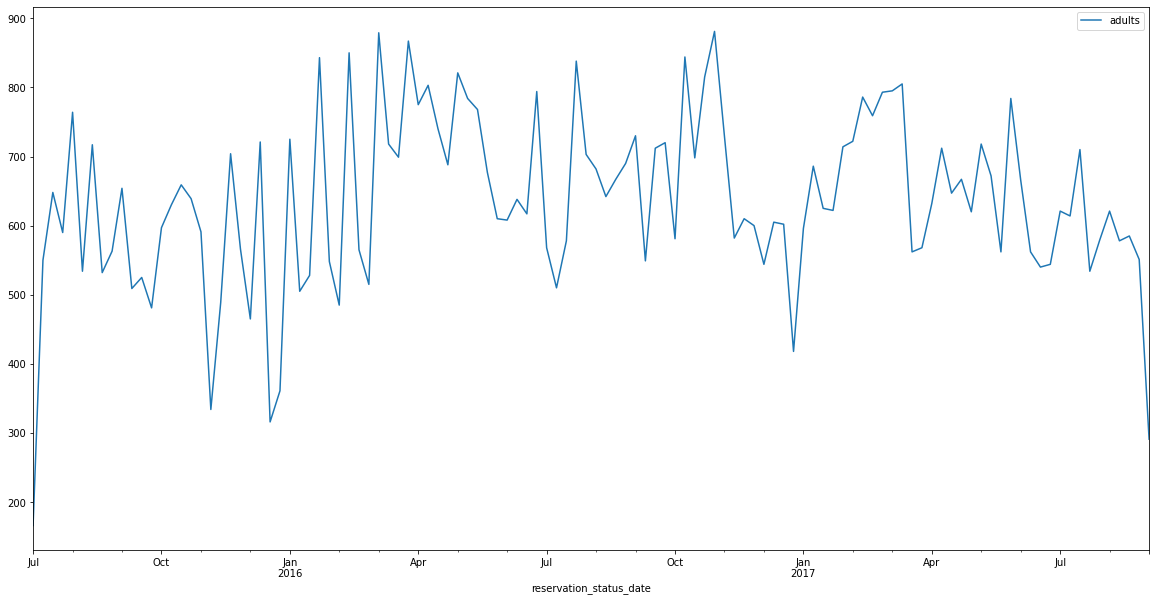

In [11]:
df_Resort.plot(figsize=(20,10))

In [12]:
train = df_Resort[:"2017-07-09"]
test = df_Resort["2017-07-09":]

In [13]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.0 MB/s            


In [14]:
import pmdarima as pm
model = pm.auto_arima(train, start_p=0, start_q=0)
print(model)

 ARIMA(2,1,0)(0,0,0)[0]          


In [15]:
import statsmodels.api as sm
mod = sm.tsa.arima.ARIMA(train, order=(2, 1,0 ))
res = mod.fit()
print(res.summary())
forecast = res.predict(start="2015-07-05", end="2018-01-05")

                               SARIMAX Results                                
Dep. Variable:                 adults   No. Observations:                  106
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -648.190
Date:                Sat, 25 Jun 2022   AIC                           1302.380
Time:                        17:37:13   BIC                           1310.342
Sample:                    07-05-2015   HQIC                          1305.607
                         - 07-09-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6222      0.089     -7.022      0.000      -0.796      -0.449
ar.L2         -0.5424      0.071     -7.627      0.000      -0.682      -0.403
sigma2      1.334e+04   1881.166      7.093      0.0

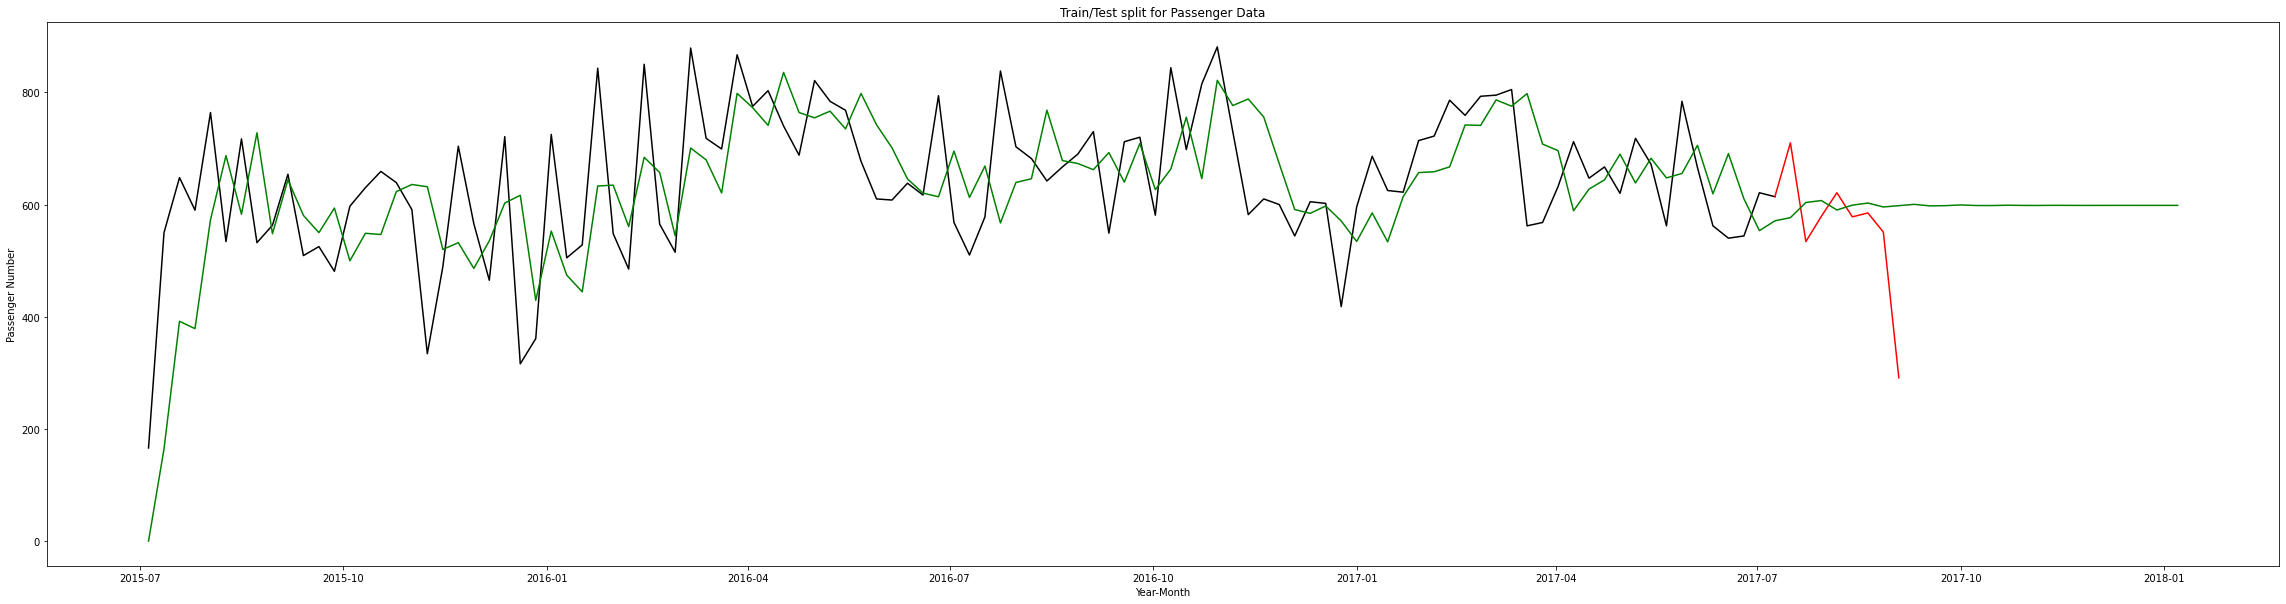

In [16]:
f = plt.figure()
f.set_figwidth(40)
f.set_figheight(10)
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(forecast, color = 'green')
plt.title("Train/Test split for Passenger Data")
plt.ylabel("Passenger Number")
plt.xlabel('Year-Month')
sns.set()
plt.show()